In [6]:
from amex_default_prediction.utils import spark_session
from pathlib import Path
from amex_default_prediction.model.base import read_train_data
from pyspark.sql import functions as F

intermediate_root = Path("../data/intermediate")
spark = spark_session()

df, _, _ = read_train_data(
    spark,
    intermediate_root / "test_data_preprocessed_v2",
    cache=False,
    data_most_recent_only=False,
)
df.printSchema()

total count:  11363762
root
 |-- sample_id: long (nullable = true)
 |-- customer_ID: string (nullable = true)
 |-- statement_date: date (nullable = true)
 |-- most_recent: boolean (nullable = true)
 |-- features: vector (nullable = true)



In [7]:
(
    df.groupby("customer_ID")
    .count()
    .withColumn("customer_count", F.col("count"))
    .groupBy("customer_count")
    .count()
    .orderBy("customer_count")
).show()

+--------------+------+
|customer_count| count|
+--------------+------+
|             1|  5827|
|             2|  8174|
|             3|  7803|
|             4|  8348|
|             5|  8419|
|             6|  8833|
|             7|  9653|
|             8|  9775|
|             9| 10552|
|            10|  9638|
|            11|  9943|
|            12| 16327|
|            13|811329|
+--------------+------+



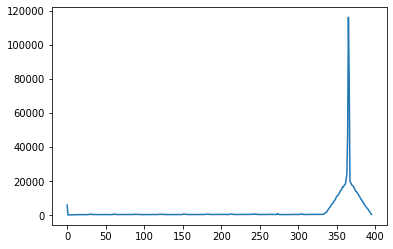

In [10]:
import matplotlib.pyplot as plt

pdf = (
    df.groupby("customer_ID")
    .agg(
        F.min("statement_date").alias("min_date"),
        F.max("statement_date").alias("max_date"),
    )
    .withColumn("date_range", F.datediff("max_date", "min_date"))
    .groupBy("date_range")
    .count()
    .orderBy("date_range")
).toPandas()

plt.plot(pdf.date_range, pdf["count"])

In [13]:
from pyspark.sql import Window

w = Window.partitionBy("customer_ID").orderBy("statement_date")
pdf = (
    df.select(
        F.datediff(F.lead("statement_date", 1).over(w), "statement_date").alias(
            "date_range"
        )
    )
).toPandas()
pdf

,date_range
0,33.0
1,10.0
2,40.0
3,29.0
4,27.0
...,...
11363757,29.0
11363758,40.0
11363759,28.0
11363760,4.0


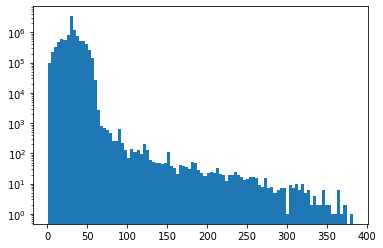

In [17]:
plt.hist(pdf.date_range, bins=100)
plt.yscale("log")

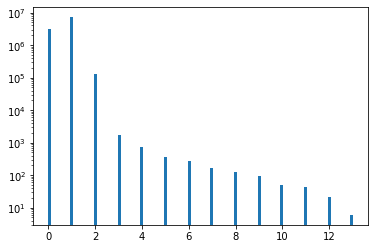

In [19]:
plt.hist(pdf.date_range // 28, bins=100)
plt.yscale("log")

In [31]:
w = Window.partitionBy("customer_ID").orderBy("statement_date")
x = (
    df.select(
        "customer_ID",
        F.floor(
            F.datediff("statement_date", F.min("statement_date").over(w)) / 7
        ).alias("date_range"),
    )
    .groupBy("customer_ID", "date_range")
    .count()
    .where("count > 1")
)
x.show()
x.count()

+--------------------+----------+-----+
|         customer_ID|date_range|count|
+--------------------+----------+-----+
|0003034ad206c64d3...|         0|    2|
|0003034ad206c64d3...|        13|    2|
|00048ea2f1b75bb67...|         8|    2|
|00210383aeaf1044d...|        27|    2|
|0091f94ffc70fba20...|        22|    2|
|011d540878f99dd84...|        34|    2|
|012ea58443635feb0...|        29|    2|
|01476a494d08a10b3...|        36|    2|
|01836bc5bdd840431...|         0|    2|
|0195acc76ed944d0e...|         0|    2|
|01d043dca0b165f34...|        12|    2|
|01d043dca0b165f34...|        25|    2|
|01eafaaf05dd45a95...|        37|    2|
|02215cca9420503c9...|        23|    2|
|023dddf6ae37d46f6...|        48|    2|
|02558d9bc7dc3bad3...|        41|    2|
|026435d48c25d6aa1...|        32|    2|
|028e86b178345c7ea...|         0|    2|
|029041374023089e8...|        42|    2|
|02c8c3021ebff5d6f...|        29|    2|
+--------------------+----------+-----+
only showing top 20 rows



86871